# Customer Life Time Value using RFM & Machine Learning

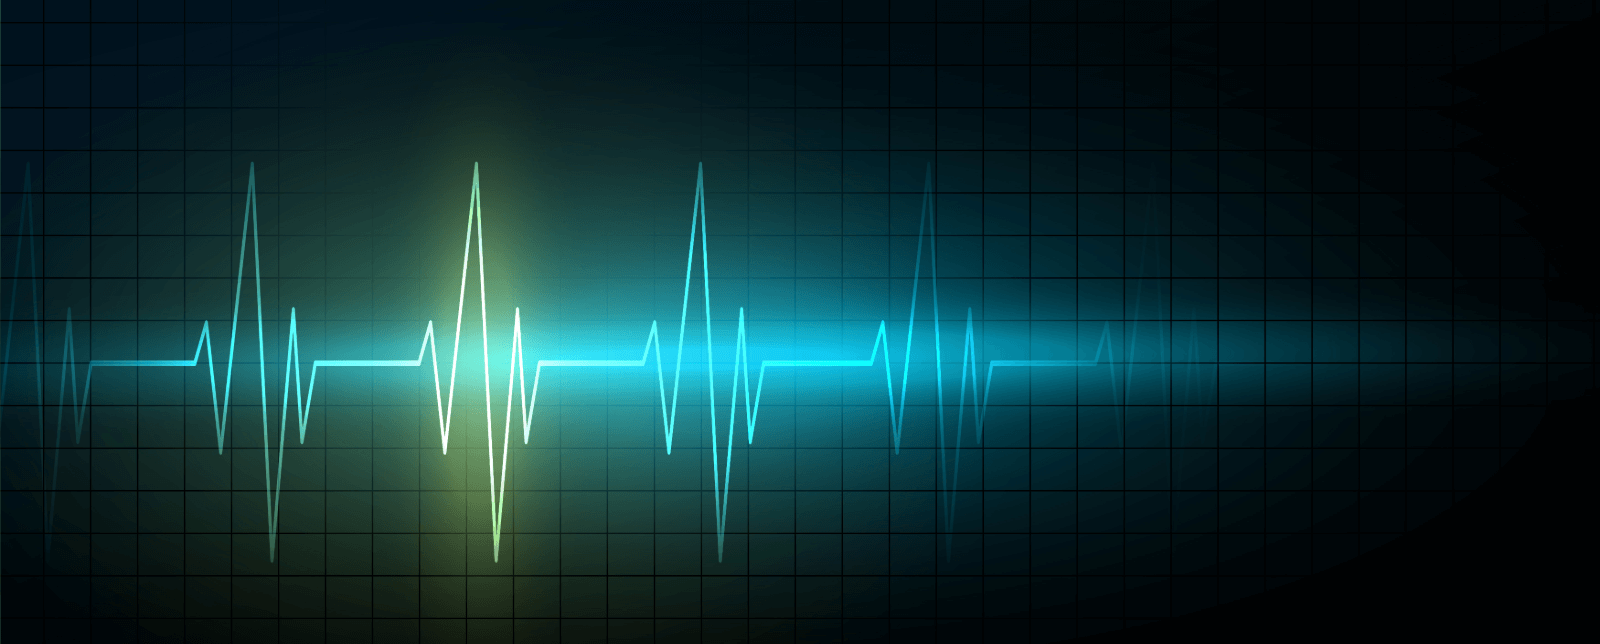

## Table of Content

## Intro

Customers are the life and soul of every business. Insights on customer behaviours and trends could be a crucial aspect in determining the success of any business. 
Customer Lifetime Value is a metric that describes how important or valuable a customer is to the business. CLV is a hollistic understanding of the customer journey with you, from beginning all the way to the end (Unless you can prevent the end!).
Companies use this as a metric to gauge profitability and understand which customers to focus on. Understanding CLV could help understand the profit that is estimated from the future relationship with a customer.

In this project, I will be looking at transactional data from a company called CDNow, a company which was considered a tech giant in the dot-com bubble, before inevitably closing it's doors in 2013.
This data contains transactional data for a cohort who had their first purchasing order between Jan, 1997 and March, 1997, and contains all subsequent transactions from this cohort up until June 30, 1998.
This data falls under the non-contractual type; which means, customers pay for the product and that's all. There are no subscription fees involved or mandatory recurring payments.

In this project, I intend to add value by shedding light on:
1) How much will each customer spend in the future?
2) What is the probability that a specific customer will make another purchase in the future?

To help solve these business questions, I will answer these 3 questions:
1) Which customers have the highest spend probability in the next 90 days? (Identify our whales)
2) Which customers have recently purchased but are unlikely to buy again? (How do we prevent this customer from 'dying'?)
3) Which customers were predicted to purchase but did not? (Missed opportunity)

High-Level Methodology I will use in this project:
1) Clean and prepare the data
2) Temporal (time-based) splitting of the data to create what is essentially a train-test split
3) Feature Engineering: I will be using the RFM (Recency-Frequency-Monetary) features for this model
4) Run the predictive models
5) Provide insights and analysis

## Part 1 Import Libraries

In [126]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import joblib

import plotnine as pn
from plotnine import ggplot
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

## Part 2 Data Preparation and Overview

In [9]:
# Import the Data

cdnow_raw_df = pd.read_csv("C:/Users/Kinan Touma/Documents/Portfolio Projects/CLV/cdnow.csv", sep = ',')

In [10]:
# Check Columns

cdnow_raw_df.head(5)

,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76


In [11]:
# Drop first column

cdnow_raw_df = cdnow_raw_df.drop(cdnow_raw_df.columns[0], axis = 1)

In [12]:
# Check columns again

cdnow_raw_df.head(5)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [13]:
# Check info to make sure formatting is good

cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.1+ MB


In [14]:
# Convert date to date time

cdnow_df = cdnow_raw_df.assign(date = lambda x: x['date'].astype(str)).assign(date = lambda x: pd.to_datetime(x['date'])).dropna()

In [15]:
# Check info again

cdnow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [16]:
# Understanding the Data:
# Start off by getting a customer's first purchase

cdnow_first_purchase_table = cdnow_df.sort_values(['customer_id', 'date']).groupby('customer_id').first()
cdnow_first_purchase_table

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


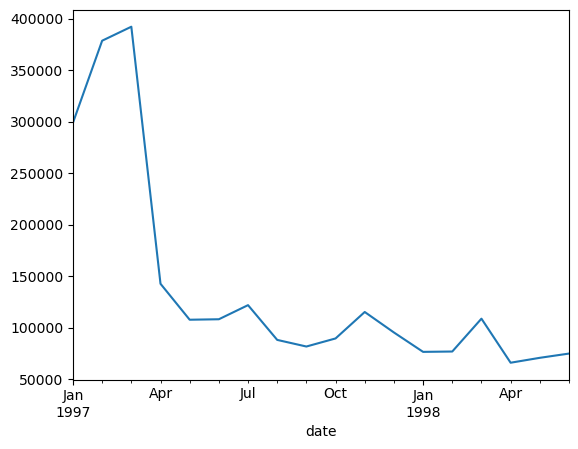

In [130]:
# Visualize all purchases within cohort

individual_plot = cdnow_df.reset_index().set_index('date')[('price')].resample(rule = 'MS').sum()

individual_plot.plot()

plt.savefig('individual plot.jpg', dpi = 300)

plt.show()

C:\Users\Kinan Touma\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\Kinan Touma\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\Kinan Touma\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


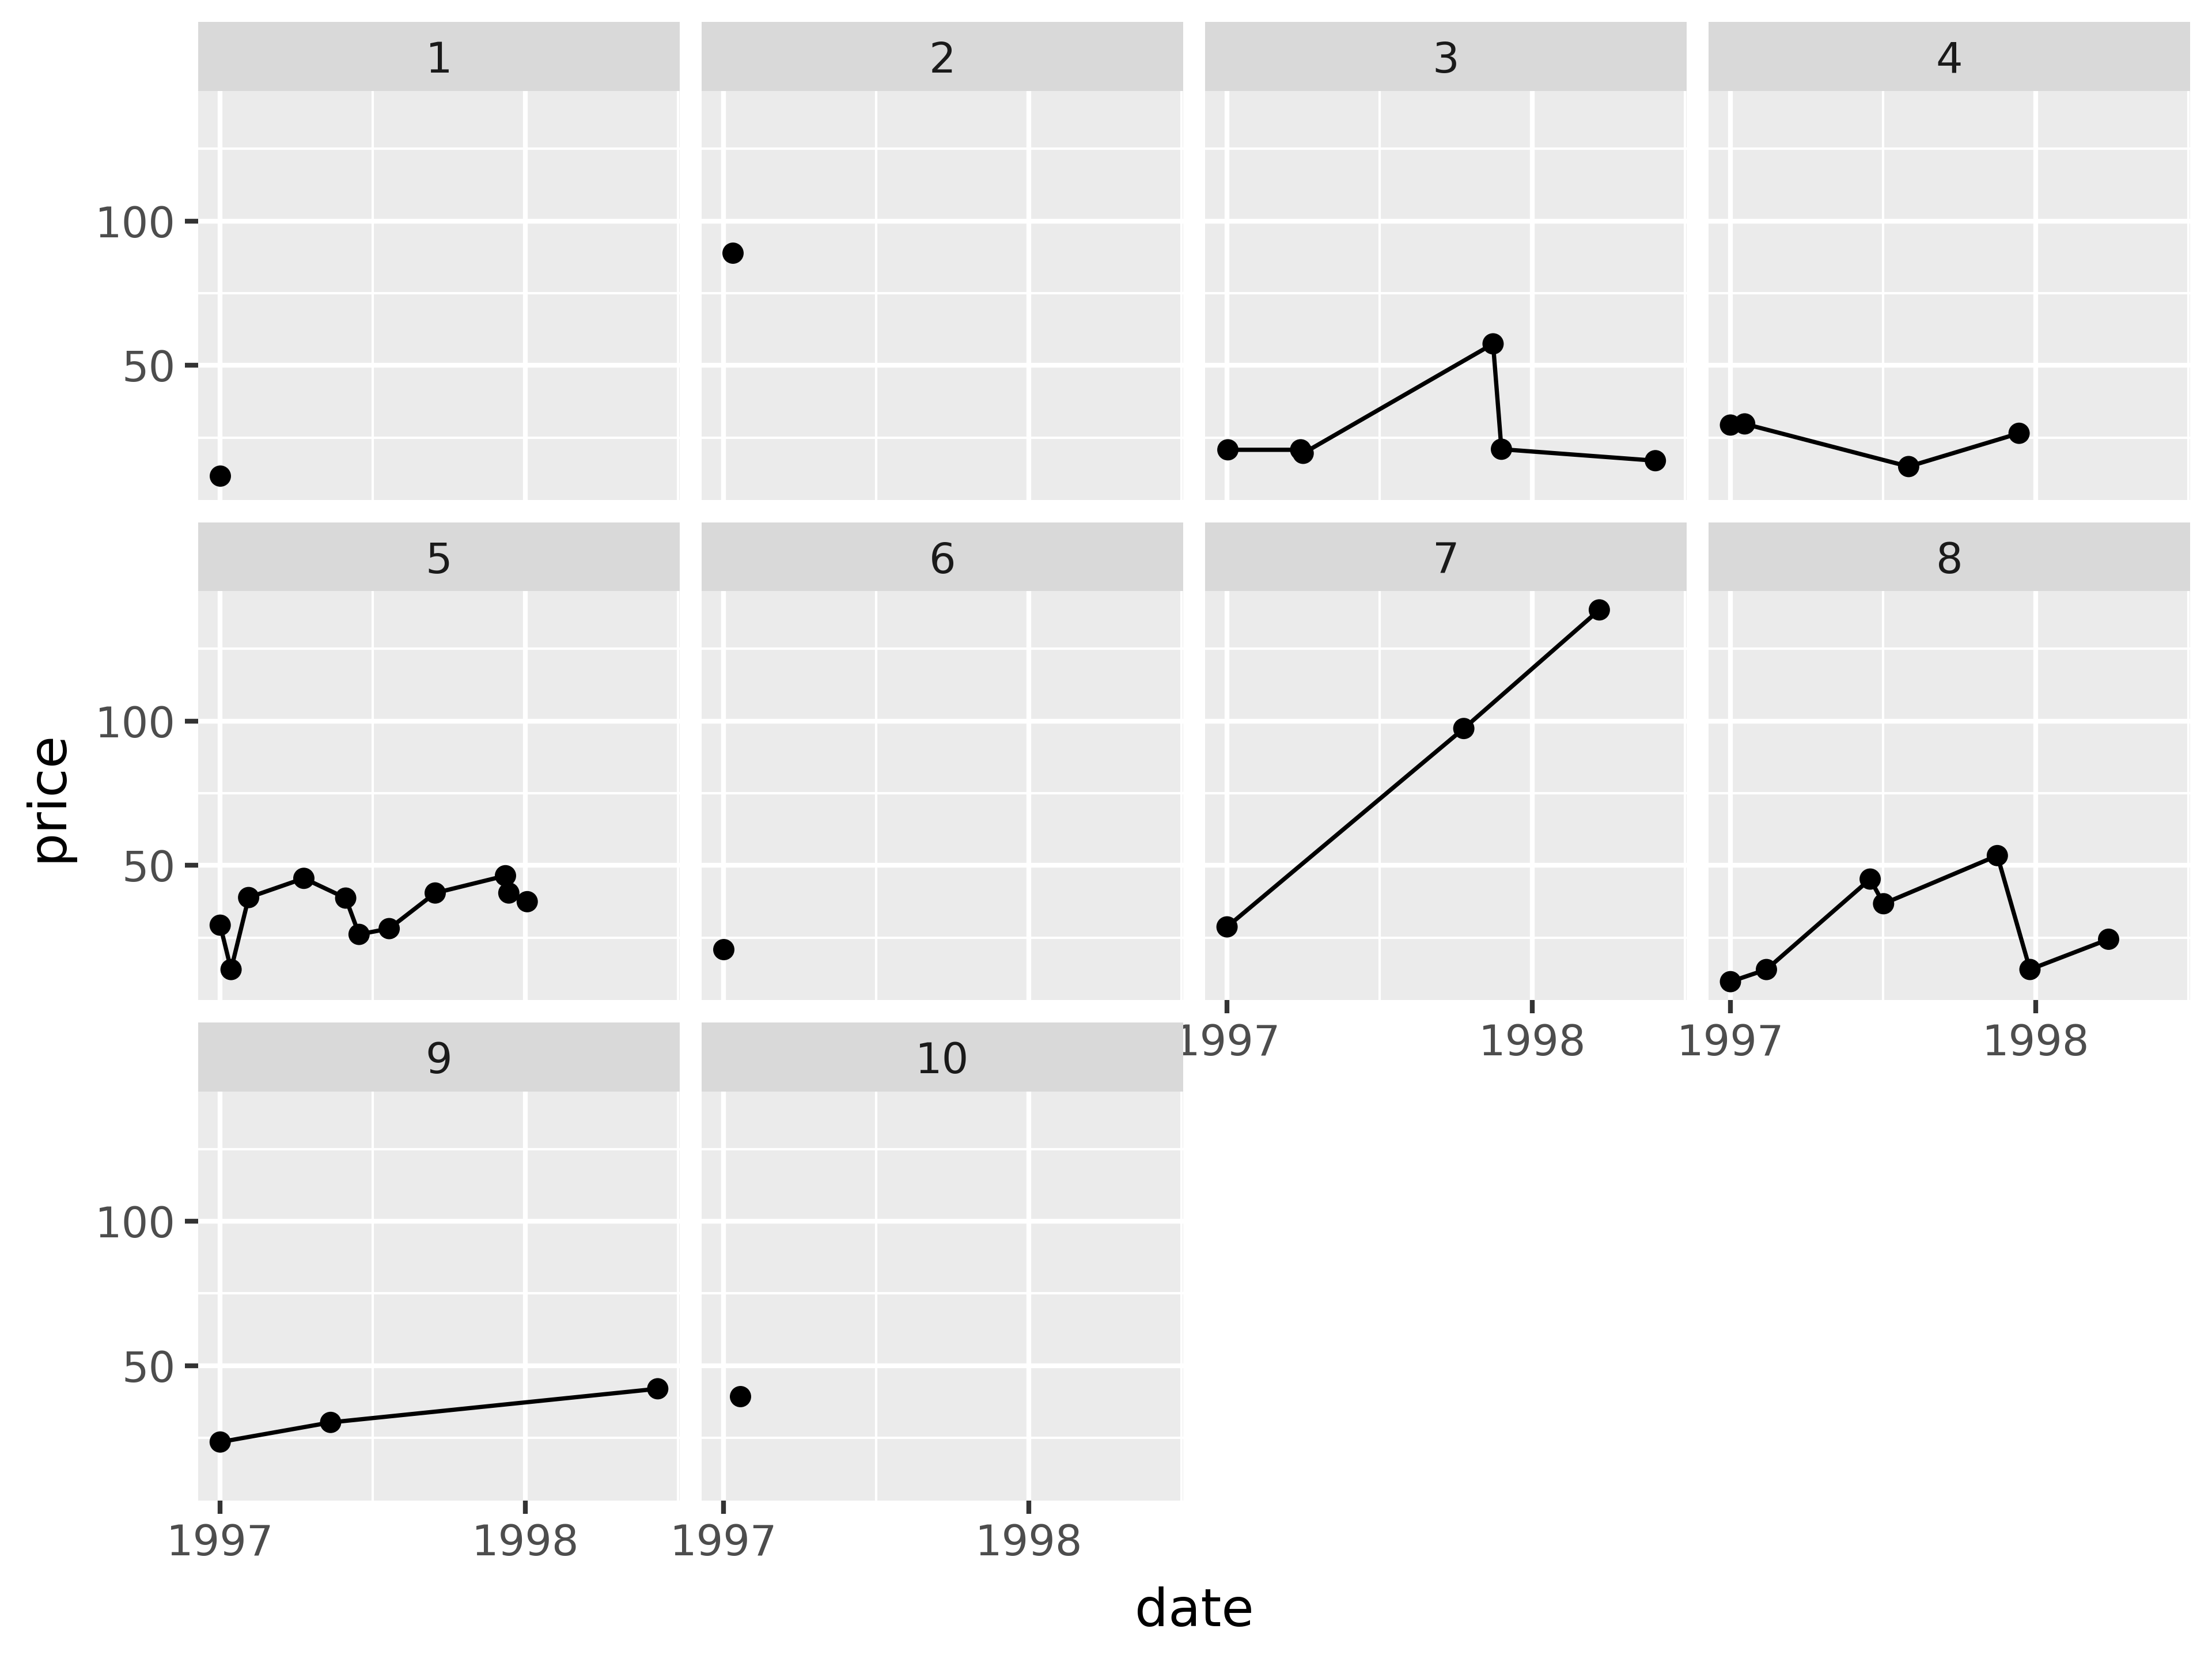

In [139]:
# Visualize Individual Customer Purchases

# Select first 10 IDs
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[0:10]

# Create a new df with these 10 IDs to help visualize
cdnow_customer_id_subset_df = cdnow_df[cdnow_df['customer_id'].isin(ids_selected)].groupby(['customer_id', 'date']).sum().reset_index()

# Visualize

pn.ggplot(
    data = cdnow_customer_id_subset_df,
    mapping = pn.aes(x = 'date', y = 'price', group = 'customer_id')
) +pn.geom_line() +pn.geom_point() +pn.facet_wrap('customer_id') +pn.scale_x_date(date_breaks = '1 year', date_labels = '%Y')

## Part 3 Machine Learning

### Part 3.1 Time Splitting

In [21]:
# We are interested in looking at next 90 days
n_days = 90

# The latest purchase in the entire data set
max_date = cdnow_df['date'].max()

# Cutoff will be the max date minus 90 days. This will allow us to use the last 90 days as our test split
cutoff = max_date - pd.to_timedelta(n_days, unit = 'd')

# Time-in-data will be our 'Train' and time-out-data will be our 'Test'
time_in_df = cdnow_df[cdnow_df['date'] <= cutoff]
time_out_df = cdnow_df[cdnow_df['date'] > cutoff]

### Part 3.2 Feature Engineering

In [22]:
# Make targets from the out-data

targets_df = time_out_df \
    .drop(['quantity', 'date'], axis = 1) \
    .groupby('customer_id') \
    .sum() \
    .rename({'price': 'spend_90_total'}, axis = 1) \
    .assign(spend_90_flag = 1)

In [23]:
# Make a Recency Feature from in-data

max_date = time_in_df['date'].max()

recency_df = time_in_df[['customer_id', 'date']] \
    .groupby('customer_id') \
    .apply(lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, 'd')) \
    .to_frame() \
    .set_axis(['recency'], axis  = 1)           

In [24]:
# Make Frequency Feature from in-data

frequency_df = time_in_df[['customer_id', 'date']] \
    .groupby('customer_id') \
    .count() \
    .set_axis(['frequency'], axis = 1)

In [25]:
# Make Monetary Feature from in-data

monetary_df = time_in_df \
    .groupby('customer_id') \
    .aggregate({'price':['sum', 'mean']}) \
    .set_axis(['price_sum', 'price_mean'], axis = 1)

In [26]:
# Combine Features into a dataframe

features_df = pd.concat(
    [recency_df, frequency_df, monetary_df], axis = 1).merge(targets_df, left_index = True, right_index = True, how = 'left').fillna(0)

In [27]:
features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


### Part 3.3 Model Building

In [29]:
# Next 90-day Spend Prediction

# Set features as X - these are the regressors
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

# Set your targets 
y_spend = features_df['spend_90_total']

# Create regression spec using squared error
xgb_reg_spec = XGBRegressor(objective = "reg:squarederror", random_state = 123)

# Create model using GridSearchCV with varying learning rates. Calculate MAE for each learning rate. Use 5-fold randomized cross-validation. This will split the data into 80-20 split 5 times per parameter and create 5 models per parameter. 
# Once all models are done, it will find out which parameter did best and it will fit a 6th model (refit = True)
xgb_reg_model = GridSearchCV(
    estimator = xgb_reg_spec,
    param_grid = dict(
        learning_rate = [0.01, 0.1, 0.3, 0.5]
    ) ,
    scoring = 'neg_mean_absolute_error',
    refit = True,
    cv = 5
)

# Fit the model
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [30]:
# Find the best score

xgb_reg_model.best_score_

# on average, our prediction is off by $10.93 per customer

-10.939501193931802

In [31]:
# Find the best parameter to use

xgb_reg_model.best_params_

# best was learning rate of 0.1

{'learning_rate': 0.1}

In [32]:
# Best estimator

xgb_reg_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [33]:
# Now we make predictions

prediction_reg = xgb_reg_model.predict(X)

In [34]:
prediction_reg

array([ 0.8516166,  2.0874057, 12.327984 , ...,  4.558194 ,  1.140923 ,
        3.5550523], dtype=float32)

In [35]:
# Spend Probability - Classification

# Set features as X - these are the regressors
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

# Set your targets 
y_prob = features_df['spend_90_flag']

# Create classification spec using squared error
xgb_clf_spec = XGBClassifier(objective = "binary:logistic", random_state = 123)

# Create model using GridSearchCV with varying learning rates. Calculate MAE for each learning rate. Use 5-fold randomized cross-validation. This will split the data into 80-20 split 5 times per parameter and create 5 models per parameter. 
# Once all models are done, it will find out which parameter did best and it will fit a 6th model (refit = True)
xgb_clf_model = GridSearchCV(
    estimator = xgb_clf_spec,
    param_grid = dict(
        learning_rate = [0.01, 0.1, 0.3, 0.5]
    ) ,
    scoring = 'roc_auc', #area under curve
    refit = True,
    cv = 5
)

# Fit the model
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [36]:
# Find the best score

xgb_clf_model.best_score_

# on average, our prediction is 84% confident

0.8344802222992829

In [37]:
# Find the best parameter to use

xgb_clf_model.best_params_

# best was learning rate of 0.01

{'learning_rate': 0.01}

In [38]:
# Best estimator

xgb_clf_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [39]:
prediction_clf = xgb_clf_model.predict_proba(X)

In [40]:
prediction_clf

array([[0.91622937, 0.08377061],
       [0.9173875 , 0.08261252],
       [0.7599223 , 0.24007767],
       ...,
       [0.86449254, 0.13550743],
       [0.9068537 , 0.09314632],
       [0.88331866, 0.11668134]], dtype=float32)

### Part 3.4 Feature Importance

In [58]:
# Importance of Features for the Regression

imp_spend_amount_dict = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

imp_spend_amount_df = pd.DataFrame(
    data = {
        'feature': list(imp_spend_amount_dict.keys()),
        'value': list(imp_spend_amount_dict.values())
    })

imp_spend_amount_df = imp_spend_amount_df.sort_values(by='value', ascending=False).reset_index(drop=True)

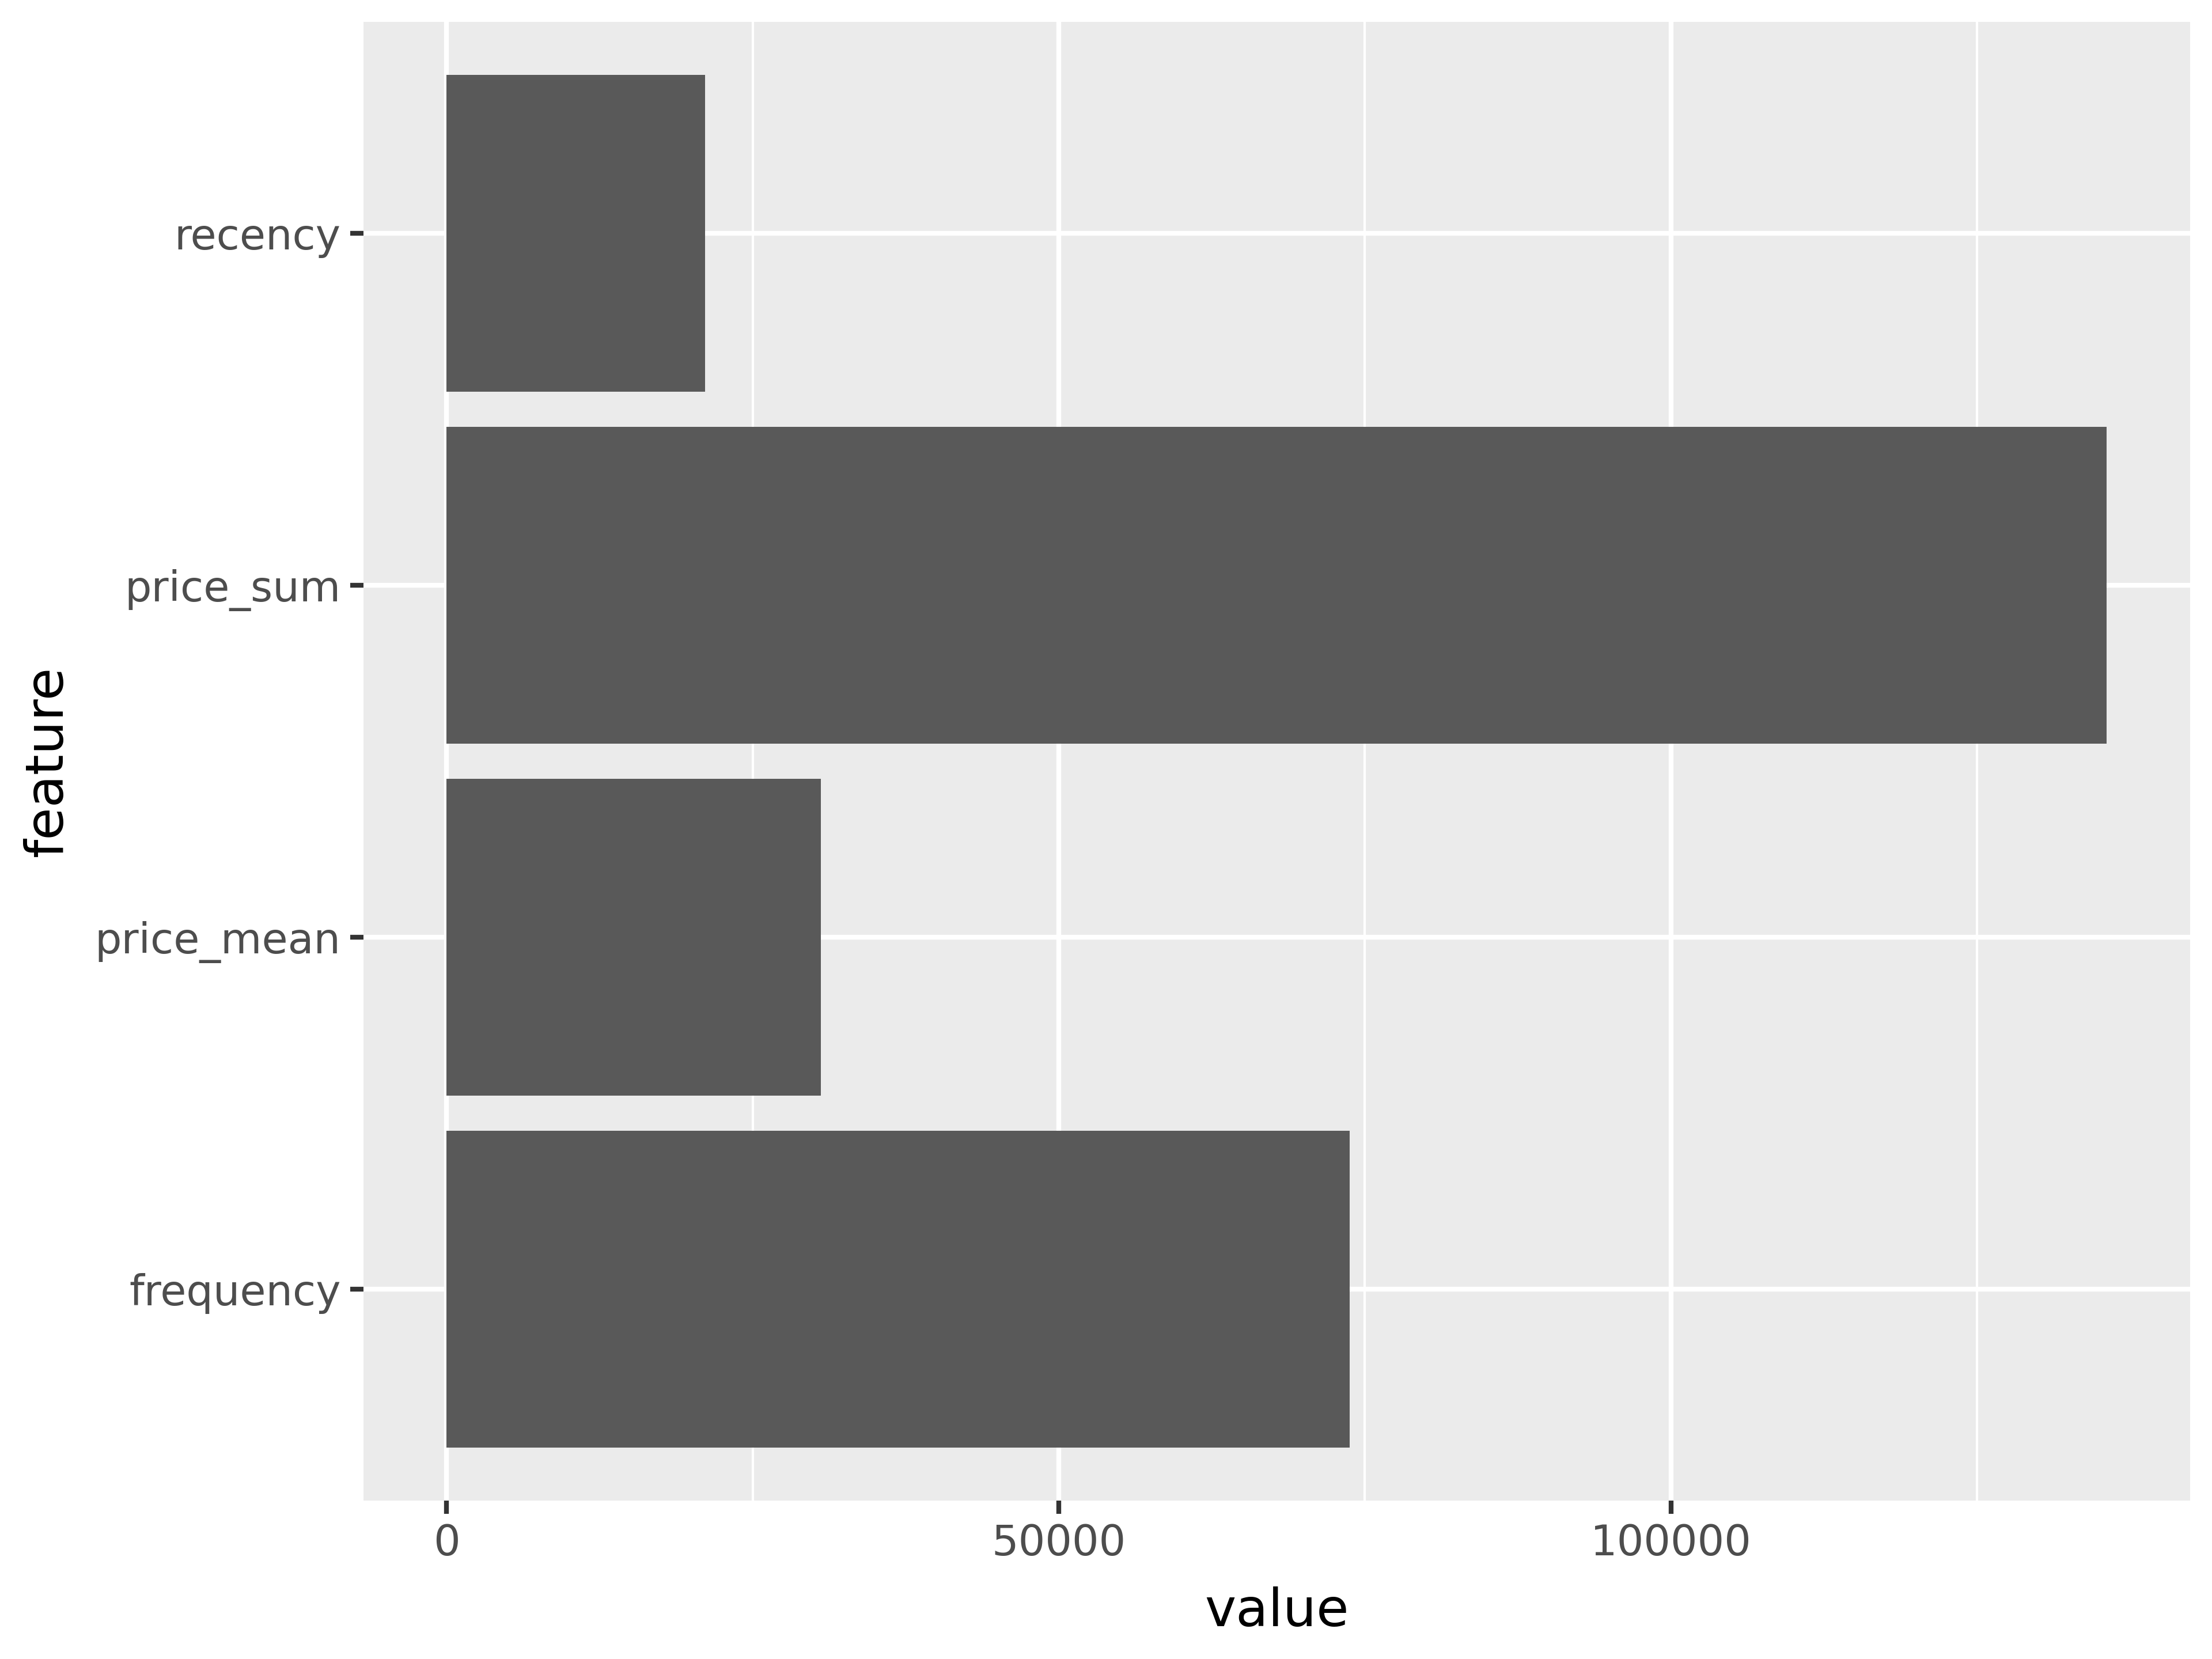

In [138]:
# Visualize

pn.ggplot(
    data = imp_spend_amount_df,
    mapping = pn.aes('feature', 'value')) + pn.geom_col() + pn.coord_flip()

In [62]:
# Importance of Features for the Classification

imp_spend_prob_dict = xgb_clf_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

imp_spend_prob_df = pd.DataFrame(
    data = {
        'feature': list(imp_spend_prob_dict.keys()),
        'value': list(imp_spend_prob_dict.values())
    })

imp_spend_prob_df = imp_spend_prob_df.sort_values(by='value', ascending=False).reset_index(drop=True)

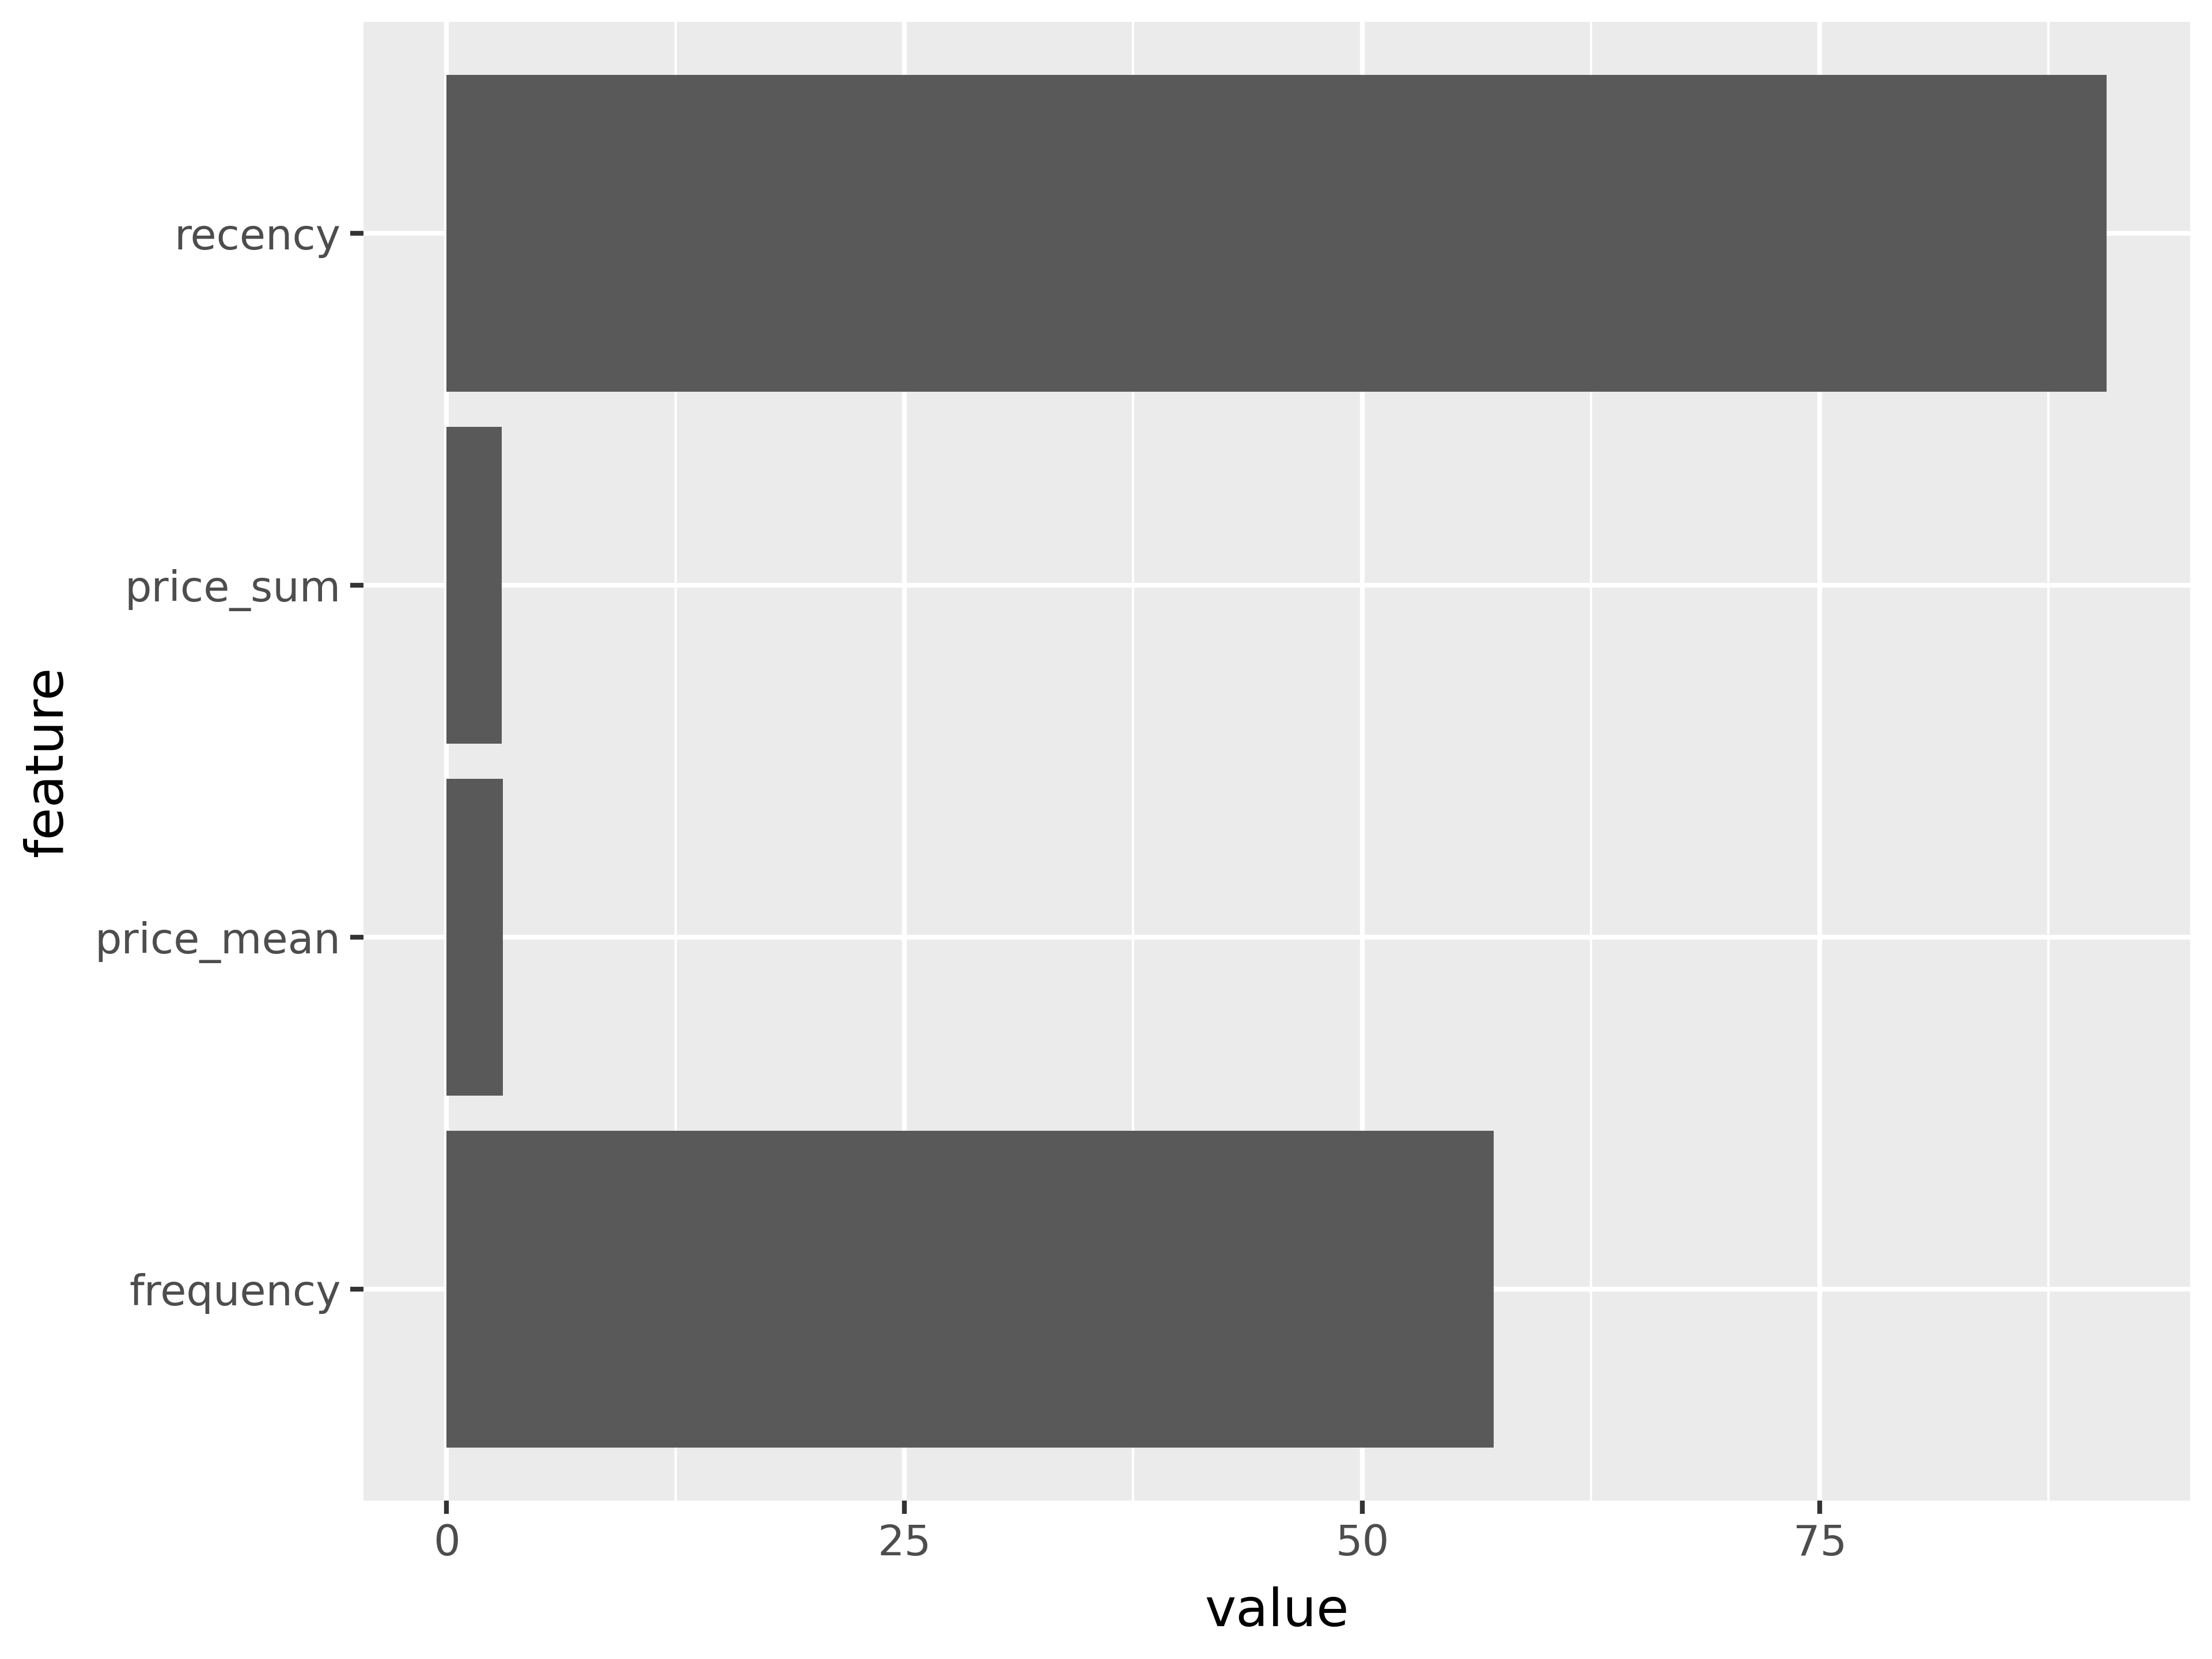

In [137]:
pn.ggplot(
    data = imp_spend_prob_df,
    mapping = pn.aes('feature', 'value')) + pn.geom_col() + pn.coord_flip()

In [102]:
# Save Predictions

predictions_df = pd.concat(
    [pd.DataFrame(prediction_reg).set_axis(['pred_spend'], axis = 1), 
     pd.DataFrame(prediction_clf)[[1]].set_axis(['pred_prob'], axis = 1), 
     features_df.reset_index()
    ],
    axis = 1
)
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.851617,0.083771,1,-455.0,1,11.77,11.770000,0.00,0.0
1,2.087406,0.082613,2,-444.0,2,89.00,44.500000,0.00,0.0
2,12.327984,0.240078,3,-127.0,5,139.47,27.894000,16.99,1.0
3,10.697600,0.237341,4,-110.0,4,100.50,25.125000,0.00,0.0
4,29.300179,0.450179,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,1.215649,0.091442,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,1.105468,0.093146,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,4.558194,0.135507,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,1.140923,0.093146,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [83]:
# Save Models

joblib.dump(xgb_reg_model, 'artifacts/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'artifacts/xgb_clf_model.pkl')

['artifacts/xgb_clf_model.pkl']

## Part 4 Analysis

At the beginning of this project, I promised I would answer three questions.

##### Question 1: Which customers have the highest spend probability in the next 90 days? (Identify our whales)

In [116]:
predictions_df.sort_values('pred_prob', ascending = False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
12859,431.955383,0.643970,12860,-3.0,30,1389.08,46.302667,457.26,1.0
5476,83.370262,0.643970,5477,-2.0,23,684.21,29.748261,98.45,1.0
8034,317.018890,0.643970,8035,-3.0,42,1332.67,31.730238,376.24,1.0
15753,186.177826,0.643970,15754,-2.0,19,724.00,38.105263,471.72,1.0
498,929.121643,0.643970,499,-3.0,100,3427.55,34.275500,951.00,1.0
...,...,...,...,...,...,...,...,...,...
497,1.833620,0.082613,498,-431.0,2,120.13,60.065000,0.00,0.0
6315,0.464132,0.082613,6316,-427.0,2,205.90,102.950000,0.00,0.0
494,1.894441,0.082613,495,-451.0,2,72.07,36.035000,0.00,0.0
6365,2.096353,0.082613,6366,-431.0,2,92.69,46.345000,0.00,0.0


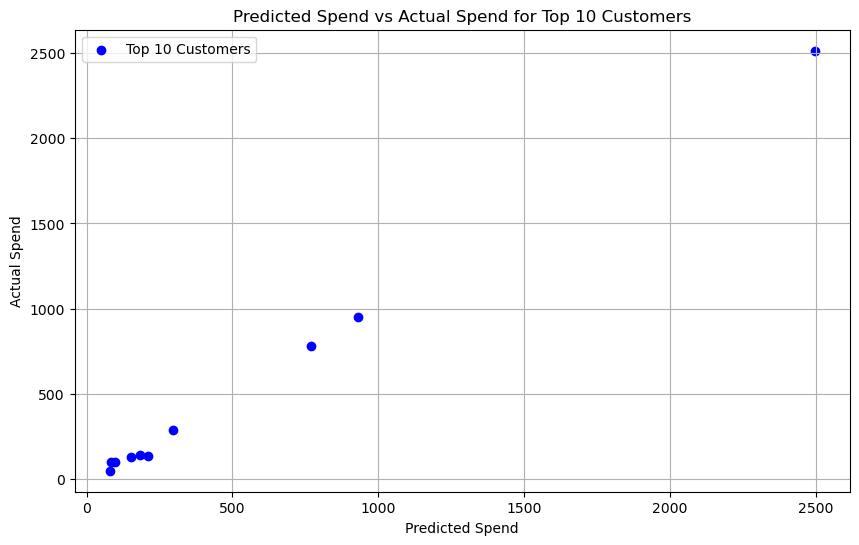

In [117]:
# Lets get the top 10 customers based on the probability that they WILL spend

top_cust = predictions_df.nlargest(10, 'pred_prob')

# Graph their predicted spend vs. actual spend

plt.figure(figsize=(10, 6))
plt.scatter(top_cust['pred_spend'], top_cust['spend_90_total'], color='blue', label='Top 10 Customers')
plt.xlabel('Predicted Spend')
plt.ylabel('Actual Spend')
plt.title('Predicted Spend vs Actual Spend for Top 10 Customers')
plt.legend()
plt.grid(True)
plt.show()

As we can see from the graph above, the data for the top 10 customers appears to be very symmetric and linear. This is further proof that our predictions are fairly accurate.

##### Question 2: Which customers have recently purchased but are unlikely to buy again? (How do we prevent this customer from 'dying'?)

In [118]:
predictions_df[predictions_df['recency'] > -90][predictions_df['pred_prob'] < 0.20].sort_values('pred_prob', ascending = False)

C:\Users\Kinan Touma\AppData\Local\Temp\ipykernel_21764\1436244638.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
18032,8.319474,0.198952,18033,-26.0,2,30.48,15.240,0.0,0.0
10887,8.319474,0.198952,10888,-25.0,2,34.95,17.475,0.0,0.0
14808,8.319474,0.198952,14809,-25.0,2,26.84,13.420,0.0,0.0
7743,8.319474,0.198952,7744,-26.0,2,27.69,13.845,0.0,0.0
11821,8.319474,0.198952,11822,-25.0,2,30.79,15.395,0.0,0.0
...,...,...,...,...,...,...,...,...,...
8077,14.387550,0.133946,8078,-12.0,2,327.93,163.965,0.0,0.0
7365,5.828395,0.133896,7366,-8.0,2,214.01,107.005,0.0,0.0
6971,14.764078,0.133896,6972,-23.0,2,191.94,95.970,0.0,0.0
15504,14.595891,0.133896,15505,-20.0,2,215.33,107.665,0.0,0.0


These customers are ones that made a purchase in the last 90 days but are unlikely to purchase again. Adding these customers to mailing lists that offer promotions, rewards, and incentives to shop would be ideal as these can serve as tactics to prevent 'death'.

##### Question 3: Which customers were predicted to purchase but did not? (Missed opportunity)

In [109]:
predictions_df[predictions_df['spend_90_total'] == 0].sort_values('pred_spend', ascending = False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
9341,146.135712,0.539694,9342,-37.0,19,906.71,47.721579,0.0,0.0
17476,141.888000,0.523910,17477,-27.0,17,1248.14,73.420000,0.0,0.0
32,140.815475,0.574759,33,-19.0,25,1045.47,41.818800,0.0,0.0
17522,117.985970,0.612479,17523,-5.0,17,2280.08,134.122353,0.0,0.0
5054,113.941353,0.634723,5055,-8.0,20,797.11,39.855500,0.0,0.0
...,...,...,...,...,...,...,...,...,...
14395,-0.656993,0.137006,14396,-3.0,2,139.48,69.740000,0.0,0.0
12558,-1.798854,0.194262,12559,-276.0,17,477.39,28.081765,0.0,0.0
16451,-2.658624,0.261991,16452,-140.0,4,804.46,201.115000,0.0,0.0
3505,-6.874567,0.214601,3506,-268.0,24,1730.57,72.107083,0.0,0.0


These are the customers ordered by how large of a basket they were predicted to check out, but spent 0. These are some of the most important customers to target with mailing lists focused around retention.

##### The Models

Although on paper our models appear to be predicting properly, let's get some statistical validation to that:

In [110]:
xgb_reg_model.best_score_

-10.939501193931802

This value shows that our regression model is on average, predicting $10.93 off from the actual value. While in the grand scheme this looks alright, we should compare it to the mean spend to see how much of a factor it is.

In [114]:
100 - abs((xgb_reg_model.best_score_) / (np.mean(predictions_df['price_sum'])) * 100)

88.72261401592503

Our regression model is predicting at around 88% of the actual spend, which is not so bad afterall

Let's check the classification model

In [115]:
xgb_clf_model.best_score_

0.8344802222992829

Our classification model is performing at around 83% accuracy. There is room for improvement, but still considered decent

## Next Steps

While creating this CLV model is very valuable and can provide a LOT of insight on it's own; it's strength really shows when it is coupled with a forecasting analysis. A forecast using these models will allows the business to prepare and adapt for scenarios they might not have been expecting.

Understanding the feature importance is also key here. 
In terms of the Regression model, which was used to predict how much a customer would spend in their next 90 days, their total spend and the frequency at which they bought were considered the most important features.
In terms of the Classification model, which was used to predict if the customer would spend at all, their frequency and recencu were considered the most important feature.

Based on the company's needs and what they believe they want to work on, using these feature importances can help them zero in their efforts in the right place.